# Online Local Adaptive Model - Notebook 1

* Prior Probability Shift is one of the common problems encountered in Machine Learning algortihms.   
* There are some approaches for dealing with this problem in a 'static' scenario. But there are situations in which we need a model which deals with secvential data as input (e.g. a server which gets input from different users, with different data distributions).   
* In this project, we try to build a model which self adapts its predictions based on the local label distribution. 

### About notebook 1

In this notebook we implement the standard version of Lenet5 architecture and test it on the entire MNIST dataset (which has a uniform label distribution)

#### LeNet5 model used (with 28x28 inputs):
![title](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5.png?x64257)

### Notebook setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2

### Imports

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import deque
import os
import pickle
from training_plotter import TrainingPlotter
from dataset import MNISTDataset
from utils import Utils
from lenet5 import Lenet5
from lenet5_with_distr import Lenet5WithDistr

# numpy print options
np.set_printoptions(linewidth = 150)
np.set_printoptions(edgeitems = 10)
np.set_printoptions(precision=3)

### Set seed

In [4]:
# create a random generator using a constant seed in order to reproduce results
seed = 112358
nprg = np.random.RandomState(seed)

### Import MNIST dataset

In [162]:
MNIST_TRAIN_IMAGES_FILEPATH = 'MNIST_dataset/train-images.idx3-ubyte'
MNIST_TRAIN_LABELS_FILEPATH = 'MNIST_dataset/train-labels.idx1-ubyte'
MNIST_TEST_IMAGES_FILEPATH = 'MNIST_dataset/t10k-images.idx3-ubyte'
MNIST_TEST_LABELS_FILEPATH = 'MNIST_dataset/t10k-labels.idx1-ubyte'

mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, 
                        MNIST_TRAIN_LABELS_FILEPATH,
                        MNIST_TEST_IMAGES_FILEPATH,
                        MNIST_TEST_LABELS_FILEPATH)


### Data augmentation

In [163]:
mnist_ds.enhance_with_random_rotate(ratio = 2)

generating class:0 with ratio:2, max input:6088, current:5299
generating class:1 with ratio:2, max input:6088, current:6088
generating class:2 with ratio:2, max input:6088, current:5386
generating class:3 with ratio:2, max input:6088, current:5542
generating class:4 with ratio:2, max input:6088, current:5262
generating class:5 with ratio:2, max input:6088, current:4870
generating class:6 with ratio:2, max input:6088, current:5338
generating class:7 with ratio:2, max input:6088, current:5632
generating class:8 with ratio:2, max input:6088, current:5266
generating class:9 with ratio:2, max input:6088, current:5317


In [ ]:
mnist_ds.enhance_with_random_zoomin(ratio = 2)

In [ ]:
mnist_ds.enhance_with_random_zoomin_and_rotate(ratio = 2)

### Analyze dataset

In [165]:
print(mnist_ds.summary)


        training data set: images = (162000, 28, 28, 1), labels = (162000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        


In [166]:
def plot_images_sample(images, image_size, labels, nlines, ncols):
    plt.figure(figsize=(8, 3), dpi = 150)
    train_sample_indices = np.random.choice(a = dataset.num_examples, size = nlines * ncols, replace=False)
    plt.imshow(Utils.concat_images(images[train_sample_indices], image_size, nlines, ncols), cmap='gray_r')
    plt.title(str(np.argmax(labels[train_sample_indices], axis=1).reshape(nlines, ncols)), fontsize=8)
    plt.show()

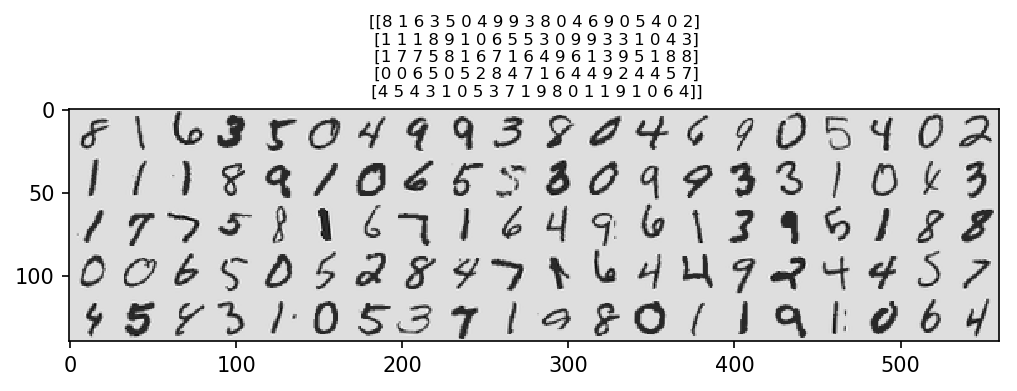

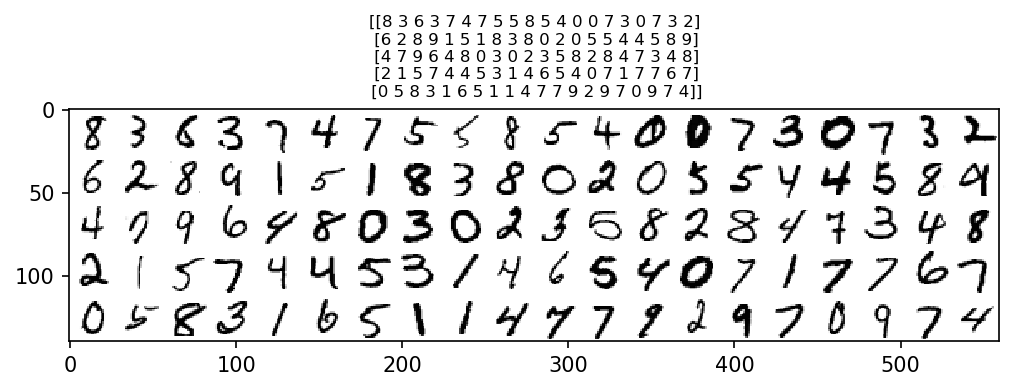

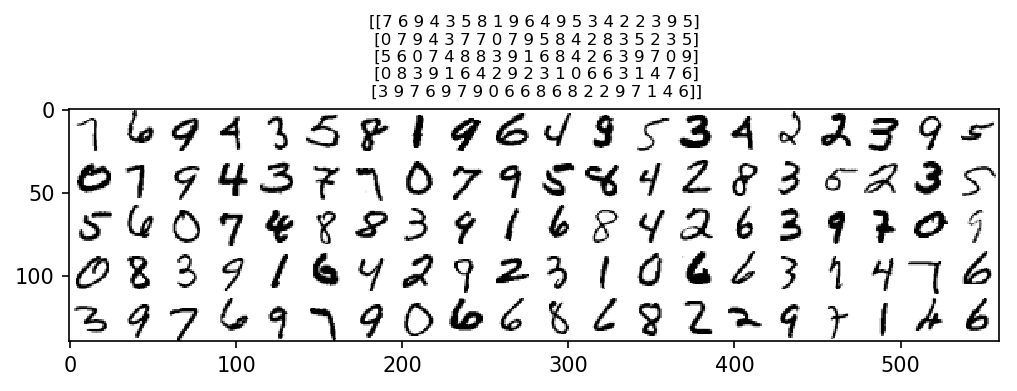

In [167]:
# plot a sample from each train, validation and test set
for dataset in [mnist_ds.train, mnist_ds.validation, mnist_ds.test]:  
    plot_images_sample(dataset.images, mnist_ds.image_size, dataset.labels, nlines=5, ncols=20)

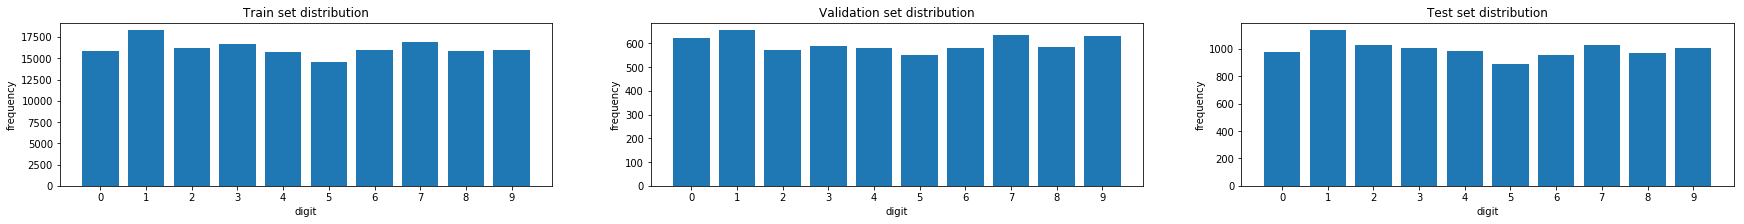

In [168]:
# plot label distribution of each train, validation and test set
plt.figure(figsize=(30, 3))

plt.subplot(131)
plt.hist(np.argmax(mnist_ds.train.labels, axis = 1), bins=np.arange(11), align='left', rwidth=0.8, normed=False)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('Train set distribution')

plt.subplot(132)
plt.hist(np.argmax(mnist_ds.validation.labels, axis = 1), bins=np.arange(11), align='left', rwidth=0.8, normed=False)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('Validation set distribution')

plt.subplot(133)
plt.hist(np.argmax(mnist_ds.test.labels, axis = 1), bins=np.arange(11), align='left', rwidth=0.8, normed=False)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('Test set distribution')

plt.show()

### Train a model

In [169]:
lenet5_model = Lenet5(mnist_ds, "zoomin_and_rotate_x2_allDigits_dropoutAfterF5F6",
              epochs=40, batch_size=128, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5)

2018-03-18 15:46:42,182 - 
        training data set: images = (162000, 28, 28, 1), labels = (162000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        


2018-03-18 15:46:44,246 - Training will use num_examples = 161920 from training set size = 162000
2018-03-18 15:48:38,450 - EPOCH 1 --- Training: loss = 0.399, acc = 0.876; Validation: loss = 0.073, acc = 0.978;
2018-03-18 15:50:35,078 - EPOCH 2 --- Training: loss = 0.137, acc = 0.963; Validation: loss = 0.048, acc = 0.986;
2018-03-18 15:52:31,198 - EPOCH 3 --- Training: loss = 0.101, acc = 0.972; Validation: loss = 0.045, acc = 0.988;
2018-03-18 15:54:26,705 - EPOCH 4 --- Training: loss = 0.083, acc = 0.977; Validation: loss = 0.042, acc = 0.988;
2018-03-18 15:56:22,363 - EPOCH 5 --- Training: loss = 0.072, acc = 0.980; Validation: loss = 0.037, acc = 0.989;
2018-03-18 15:58:17,810 - EPOCH 6 --- Training: loss = 0.063, acc = 0.982; Validation: loss = 0.036, acc = 0.990;
2018-03-18 16:00:13,292 - EPOCH 7 --- Training: loss = 0.058, acc = 0.984; Validation: loss = 0.034, acc = 0.990;
2018-03-18 16:02:08,503 - EPOCH 8 --- Training: loss = 0.053, acc = 0.985; Validation: loss = 0.037, acc

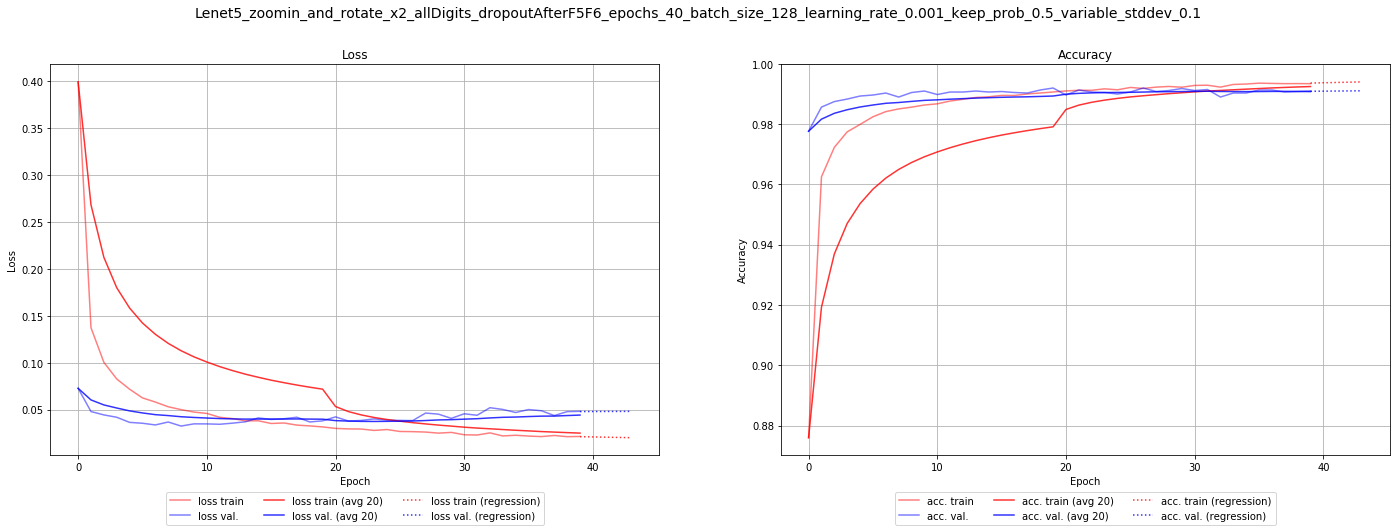

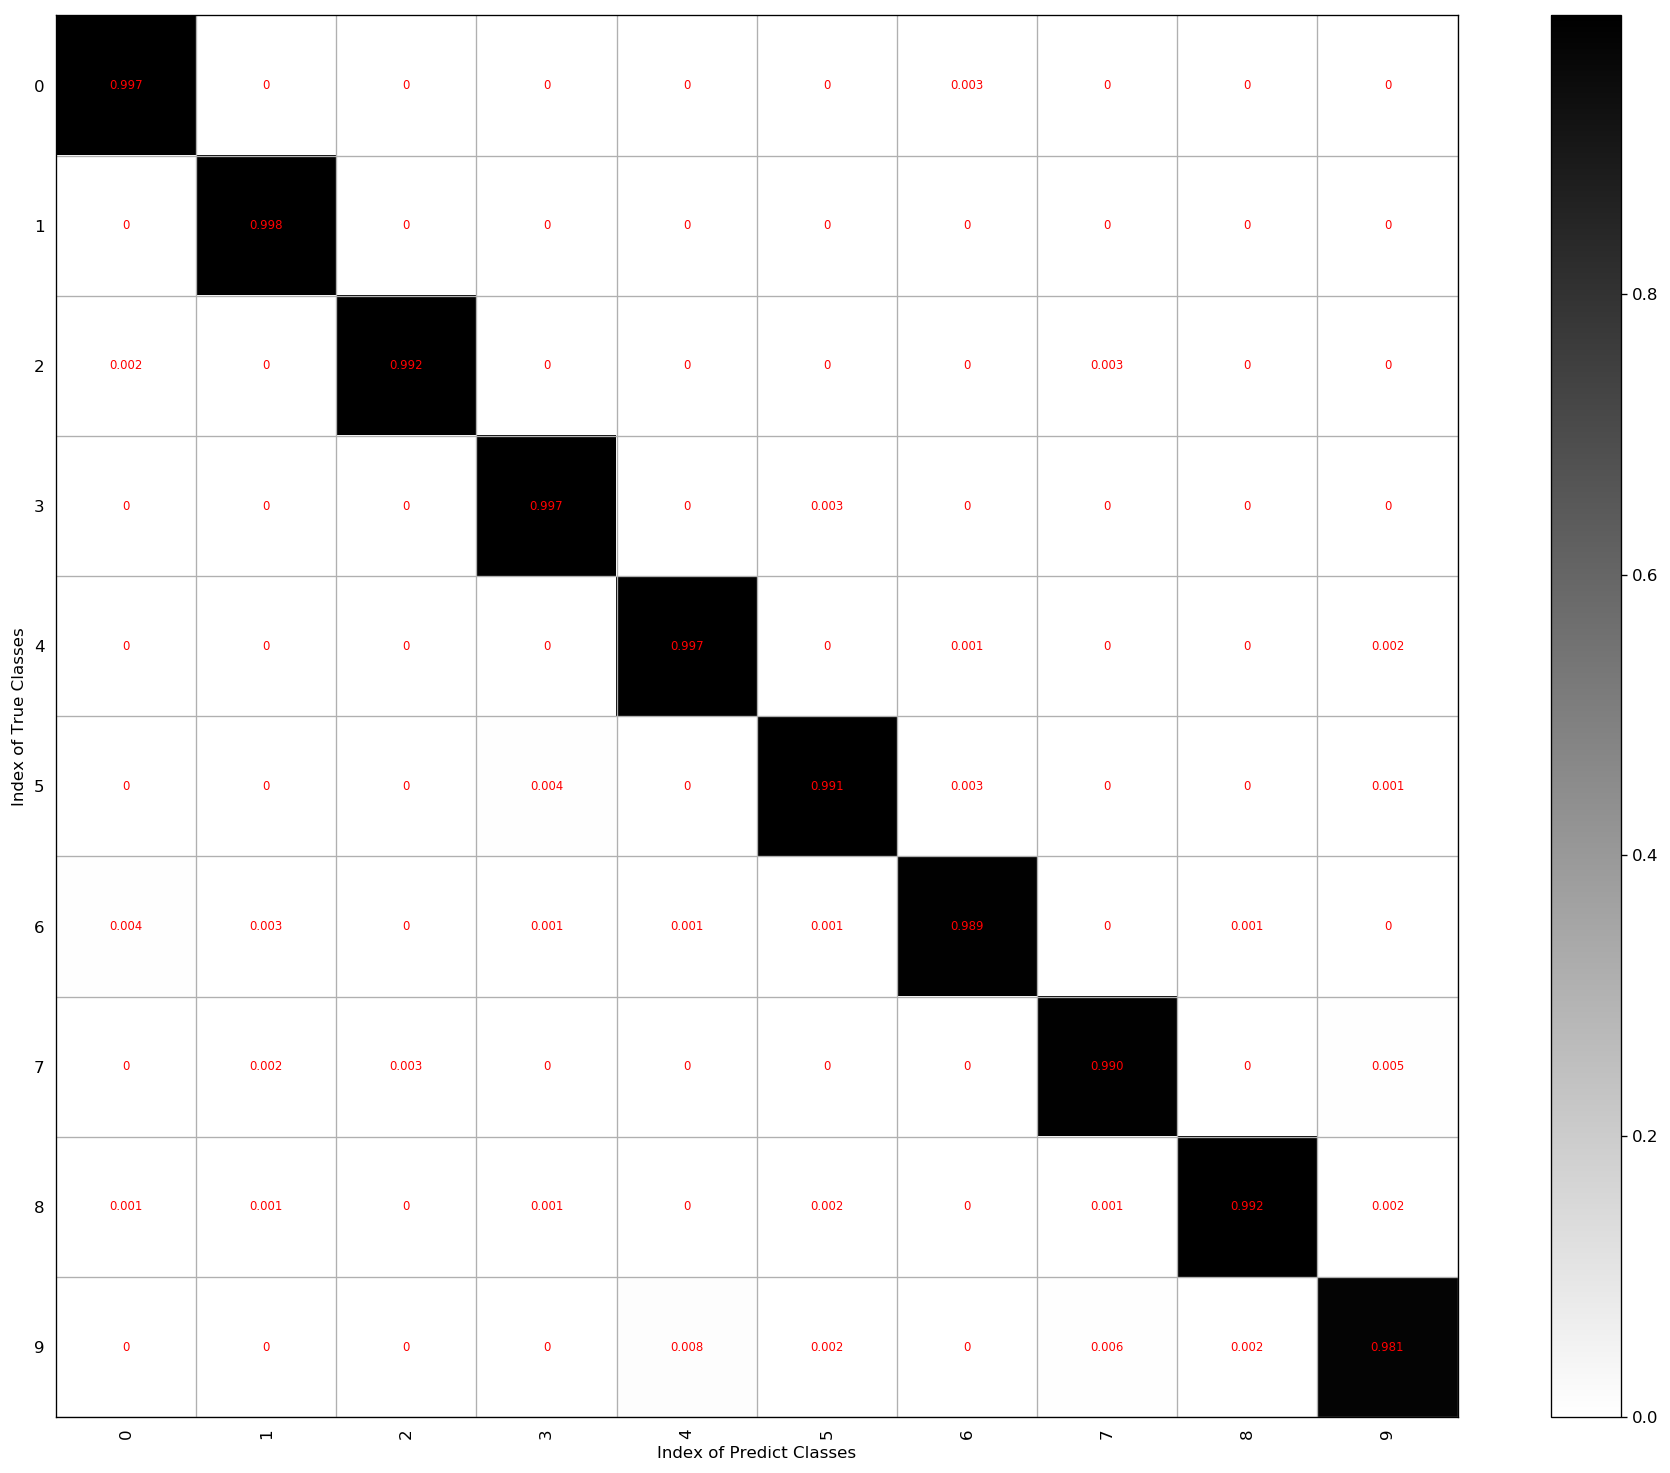

In [170]:
lenet5_model.train()

### Analyze results

#### 1. Test  a previous trained method on all test examples

In [192]:
# test using test_data method
temp = Lenet5(mnist_ds,"temp")
# temp.restore_session(ckpt_dir='./results/', ckpt_filename='Lenet5_allDigits_dropoutAfterF5F6_2018_02_10_02_59.model.ckpt')
# temp.restore_session(ckpt_dir='./results/', ckpt_filename='Lenet5_rotated_x2_allDigits_dropoutAfterF5F6_2018_02_10_23_50.model.ckpt')
temp.restore_session(ckpt_dir='./results/', ckpt_filename='Lenet5_zoomin_and_rotate_x2_allDigits_dropoutAfterF5F6_2018_03_18---15_46.model.ckpt')
test_loss, test_acc, total_predict, total_actual, wrong_predict_images, _ = temp.test_data(mnist_ds.test)
print('test_loss = {:.3f}, test_acc = {:.3f} ({}/{})'.format(test_loss,test_acc,  mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))

2018-03-18 17:15:24,008 - 
        training data set: images = (162000, 28, 28, 1), labels = (162000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
test_loss = 0.032, test_acc = 0.993 (9925/10000)


In [193]:
# sort wrong_predict_images by target label and plot them to file
wrong_predict = total_predict[total_actual != total_predict]
wrong_actual = total_actual[total_actual != total_predict]
wrong_predict_images = np.array(wrong_predict_images)
wrong_predict_images_sorted = wrong_predict_images[wrong_actual.argsort(), ]
wrong_predict_images_sorted = [image for image in wrong_predict_images_sorted]
from training_plotter import TrainingPlotter
TrainingPlotter.combine_images(wrong_predict_images_sorted, "wrong_predicted_after_restore_session.png")

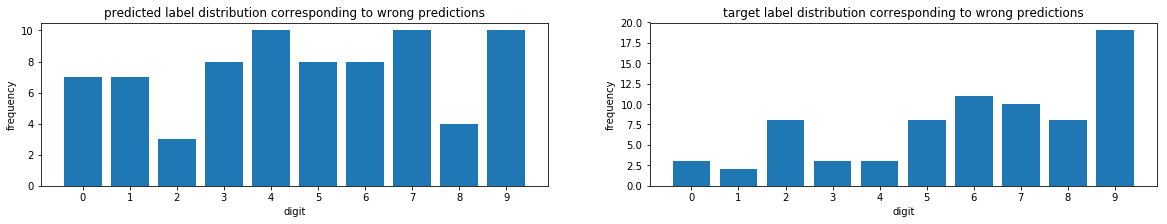

In [194]:
# print target and predicted label distributions of wrong predicted examples
plt.figure(figsize=(20, 3))

plt.subplot(121)
plt.hist(wrong_predict, bins=np.arange(11), align='left', rwidth=0.8, normed=False)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('predicted label distribution corresponding to wrong predictions')

plt.subplot(122)
plt.hist(wrong_actual, bins=np.arange(11), align='left', rwidth=0.8, normed=False)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('target label distribution corresponding to wrong predictions')

plt.show()

#### 2.Test the model  on a sample of images

In [183]:
# choose all test images as sample
test_sample_size = mnist_ds.test.num_examples
test_sample_images, test_sample_labels = mnist_ds.test.images, mnist_ds.test.labels

Counts per class:[ 980 1135 1032 1010  982  892  958 1028  974 1009]


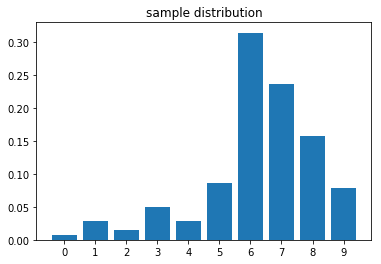

Imposing distr: num_examples_from_each_class =  [ 21  85  42 150  85 257 947 707 471 235]


In [195]:
# or choose a sample w.r.t. a given distribution
print('Counts per class:{}'.format(mnist_ds.test.counts_per_class))
test_sample_size = 3000
test_sample_weights = np.array([1, 4, 2, 7, 4, 12, 44, 33, 22, 11])
test_sample_weights = test_sample_weights / np.sum(test_sample_weights)

plt.bar(range(0,10), test_sample_weights)
plt.xticks(range(0,10))
plt.title('sample distribution')
plt.show()

test_sample_images, test_sample_labels = mnist_ds.test.next_batch(test_sample_size, weights = test_sample_weights)

In [196]:
# test using predict_images method
temp_model = Lenet5(mnist_ds,"temp")
# temp_model.restore_session(ckpt_dir='./results/', ckpt_filename='Lenet5_allDigits_dropoutAfterF5F6_2018_02_10_02_59.model.ckpt')
temp_model.restore_session(ckpt_dir='./results/', ckpt_filename='Lenet5_zoomin_and_rotate_x2_allDigits_dropoutAfterF5F6_2018_03_18---15_46.model.ckpt')
preds = temp_model.predict_images(test_sample_images)
target_labels = np.argmax(test_sample_labels, axis=1)
predicted_labels = np.argmax(preds, axis=1)
count_correct_predicted = np.sum(target_labels == predicted_labels)
print('Accuracy: {:.3f} ({}/{})'.format(count_correct_predicted / test_sample_size, count_correct_predicted, test_sample_size))

2018-03-18 17:15:48,734 - 
        training data set: images = (162000, 28, 28, 1), labels = (162000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Accuracy: 0.993 (2978/3000)


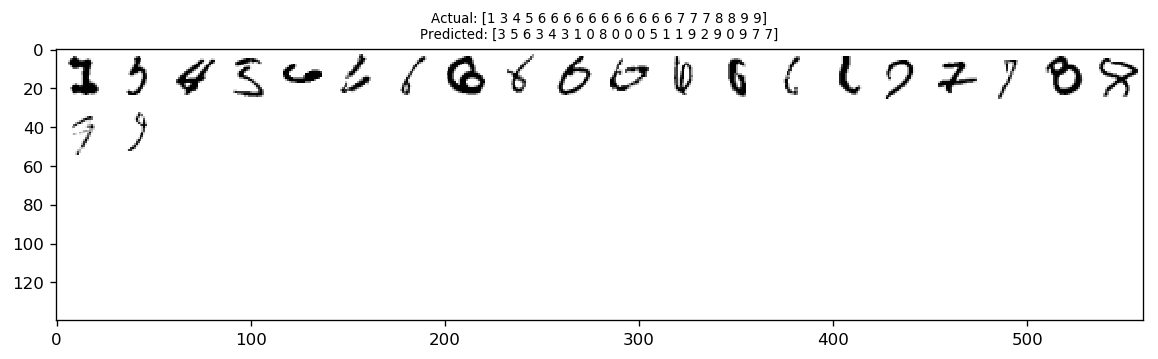

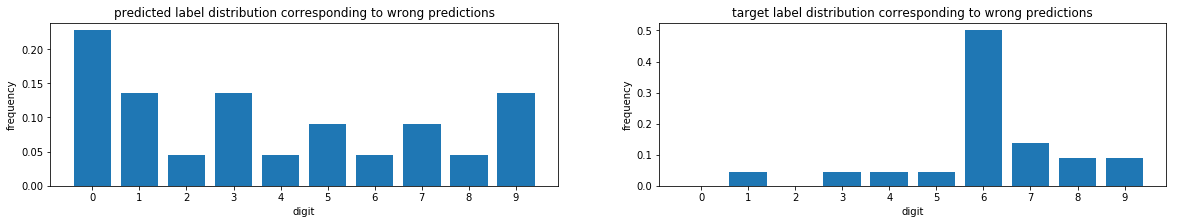

In [197]:
# sort wrong_predict_images by target label and plot them
wrong_predict = predicted_labels[target_labels != predicted_labels]
wrong_actual = target_labels[target_labels != predicted_labels]
wrong_predicted_images = test_sample_images[target_labels != predicted_labels]
wrong_predict_images_sorted = wrong_predicted_images[wrong_actual.argsort()]
wrong_actual_sorted = wrong_actual[wrong_actual.argsort()]
wrong_predict_sorted = wrong_predict[wrong_actual.argsort()]

plt.figure(figsize=(15, 3), dpi = 120)
plt.imshow(Utils.concat_images(wrong_predict_images_sorted, mnist_ds.image_size, num_images_on_x = 5, num_images_on_y = 20), cmap='gray_r')
plt.title("Actual: {}\nPredicted: {}".format(np.array(wrong_actual_sorted), str(wrong_predict_sorted)), fontsize = 8)
plt.show()

# print target and predicted label distributions of wrong predicted examples
plt.figure(figsize=(20, 3))

plt.subplot(121)
plt.hist(wrong_predict, bins=np.arange(11), align='left', rwidth=0.8, normed=True)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('predicted label distribution corresponding to wrong predictions')

plt.subplot(122)
plt.hist(wrong_actual, bins=np.arange(11), align='left', rwidth=0.8, normed=True)
plt.xticks(range(0, 10))
plt.xlabel('digit')
plt.ylabel('frequency')
plt.title('target label distribution corresponding to wrong predictions')

plt.show()